In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
from iris.time import PartialDateTime
from iris.util import mask_cube_from_shapefile
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely import MultiPolygon, Polygon

import os
import torch
import pandas as pd
import sklearn
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable 
from torch.utils.data import Dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
filenames = ['C:/Users/Tilt/Downloads/Project/Data/data_2010.nc','C:/Users/Tilt/Downloads/Project/Data/data_2011.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2012.nc','C:/Users/Tilt/Downloads/Project/Data/data_2013.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2014.nc','C:/Users/Tilt/Downloads/Project/Data/data_2015.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2016.nc','C:/Users/Tilt/Downloads/Project/Data/data_2017.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2018.nc','C:/Users/Tilt/Downloads/Project/Data/data_2019.nc']
cubes = iris.load(filenames)
cubes = cubes.concatenate()
#print(cubes)

In [3]:
ConstraintNames = [
    'burned_area',
    'population_density',
    '10 metre wind speed',
    '2 metre temperature',
    'Convective available potential energy',
    'Leaf area index, high vegetation',
    'Leaf area index, low vegetation',
    'Total precipitation',
    'Volumetric soil water layer 1',
    'observed_fraction_mask',
    'standard error of the estimation of burned area'
]

cubesList = { name: cubes.extract(iris.Constraint(name))[0] for name in ConstraintNames}
print(cubesList)

{'burned_area': <iris 'Cube' of burned_area / (m2) (time: 120; latitude: 720; longitude: 1440)>, 'population_density': <iris 'Cube' of population_density / (unknown) (time: 120; latitude: 720; longitude: 1440)>, '10 metre wind speed': <iris 'Cube' of 10 metre wind speed / (m s**-1) (time: 120; latitude: 720; longitude: 1440)>, '2 metre temperature': <iris 'Cube' of 2 metre temperature / (K) (time: 120; latitude: 720; longitude: 1440)>, 'Convective available potential energy': <iris 'Cube' of Convective available potential energy / (J kg**-1) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, high vegetation': <iris 'Cube' of Leaf area index, high vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, low vegetation': <iris 'Cube' of Leaf area index, low vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Total precipitation': <iris 'Cube' of Total precipitation / (m) (time: 120; latitude: 720; longitude: 1440)>, 'Volu

In [4]:
CountryName = "Madagascar"

country_shp_reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="110m", category="cultural", name="admin_0_countries"
    )
)
Country_shp = [
    country.geometry
    for country in country_shp_reader.records()
    if CountryName in country.attributes["NAME_LONG"]
][0]
ObsMaskCube = mask_cube_from_shapefile(cubesList["observed_fraction_mask"], Country_shp)
ObsMaskCube = iris.analysis.maths.log(ObsMaskCube)
ObsMaskCube = iris.analysis.maths.exp(ObsMaskCube)

b=0
a = ObsMaskCube.data
print("Verification - Count should Equal Sum")
print("Count =",ma.count(a))
print("Sum =",np.sum(a))
if(np.round(np.sum(a)) == ma.count(a)):
    b=b+1
print("Verification Mean should = 1")
print("Mean = ",np.mean(a))
if(np.round(np.mean(a)) == 1):
    b=b+1
print("We have",ma.count(a),"Datapoints Per Month")
if(b==2):
    print("All Verified - Continue")
else:
    print("Somethings gone wrong.")

BurnedCube = iris.analysis.maths.multiply(cubesList["burned_area"], ObsMaskCube)
PopnCube = iris.analysis.maths.multiply(cubesList["population_density"], ObsMaskCube)
WindCube = iris.analysis.maths.multiply(cubesList["10 metre wind speed"], ObsMaskCube)
TempCube = iris.analysis.maths.multiply(cubesList["2 metre temperature"], ObsMaskCube)
CAPECube = iris.analysis.maths.multiply(cubesList["Convective available potential energy"], ObsMaskCube)
HVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube = iris.analysis.maths.multiply(cubesList["Total precipitation"], ObsMaskCube)
SoilCube = iris.analysis.maths.multiply(cubesList["Volumetric soil water layer 1"], ObsMaskCube)

c:\Users\Tilt\miniconda3\Lib\site-packages\iris\_shapefiles.py:147: IrisDefaultingWarning: Cube has no coord_system; using default GeogCS lat/lon
  warnings.warn(


Verification - Count should Equal Sum
Count = 558
Sum = 558.0
Verification Mean should = 1
Mean =  1.0
We have 558 Datapoints Per Month
All Verified - Continue


c:\Users\Tilt\miniconda3\Lib\site-packages\dask\core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


(120, 720, 1440)
[0.0 0.0 0.0 ... 0.0 0.0 0.0]
66960
558


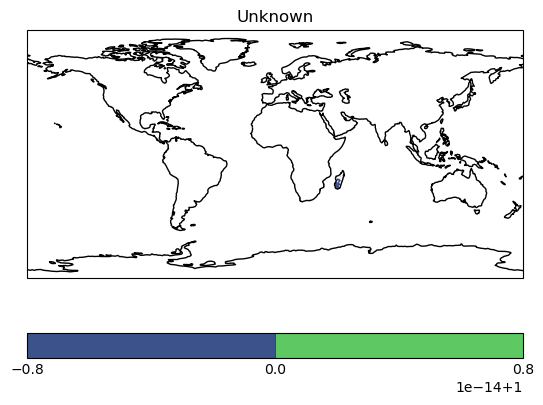

In [5]:
a = BurnedCube.data
print(np.shape(a))
aNoMask = a[~a.mask]
print(aNoMask)
print(len(aNoMask))

aMonth = BurnedCube[0].data
aNoMaskMonth = aMonth[~aMonth.mask]
print(len(aNoMaskMonth))
# 173 Datapoints Per for Portugal
Timesteps = round(len(aNoMask)/len(aNoMaskMonth))
Samples = len(aNoMaskMonth)

qplt.contourf(ObsMaskCube, 25)
plt.gca().coastlines()
plt.show()

In [6]:
def DeCube(InCube):
    InCube = InCube.data
    InCube = InCube[~InCube.mask]
    InCube = InCube.reshape(Timesteps, Samples, 1)
    return InCube

In [7]:
BurnedCube = iris.analysis.maths.add(BurnedCube,1)
BurnedCube = iris.analysis.maths.log(BurnedCube)

#Verifying this doesnt break it
#a = BurnedCube.data
#a = a[~a.mask]
#print(len(a))

Burned = DeCube(BurnedCube)

Popn = DeCube(PopnCube)
Wind = DeCube(WindCube)
Temp = DeCube(TempCube)
CAPE = DeCube(CAPECube)
HVeg = DeCube(HVegCube)
LVeg = DeCube(LVegCube)
Precip = DeCube(PrecipCube)
Soil = DeCube(SoilCube)

X_full = np.dstack((Popn,Wind,Temp,CAPE,HVeg,LVeg,Precip,Soil))
y_full = Burned

mm = MinMaxScaler()
#ss = StandardScaler()
y_full2D = y_full.reshape(Burned.shape[0],Burned.shape[1])
#X_ss = ss.fit_transform(X_full)
y_mm = mm.fit_transform(y_full2D) 

print(y_full2D.shape)

X_train = X_full[:-24,:,:]
X_test = X_full[96:,:,:]

y_train = y_mm[:-24,:] 
y_test = y_mm[96:,:]
print("Training Shape",X_train.shape,y_test.shape)
print("Testing Shape",X_train.shape,y_test.shape)

c:\Users\Tilt\miniconda3\Lib\site-packages\iris\analysis\maths.py:1014: RuntimeWarning: divide by zero encountered in log
  data = operation_function(cube.core_data())


(120, 558)
Training Shape (96, 558, 8) (24, 558)
Testing Shape (96, 558, 8) (24, 558)


In [8]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape) 

Training Shape torch.Size([96, 558, 8]) torch.Size([96, 558])
Testing Shape torch.Size([24, 558, 8]) torch.Size([24, 558])


In [26]:
# Code Adapted from 'How to apply LSTM using PyTorch'; Ahmad Anis, n.d.
# Available from: https://cnvrg.io/pytorch-lstm/ [Accessed 16 July 2024]

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 1024) #fully connected 1
        self.fc_2 =  nn.Linear(1024, 1024) #fully connected 2
        self.fc_3 =  nn.Linear(1024, 1024) #fully connected 3
        self.fc_4 =  nn.Linear(1024, 1024) #fully connected 4
        self.fc_5 =  nn.Linear(1024, 1024) #fully connected 5
        self.fc_6 =  nn.Linear(1024, 1024) #fully connected 6
        self.fc_7 =  nn.Linear(1024, 1024) #fully connected 7
        self.fc_8 =  nn.Linear(1024, 1024) #fully connected 8
        self.fc = nn.Linear(1024, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_3(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_4(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_5(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_6(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_7(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_8(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [27]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.0001 #0.001 lr

input_size = 8 #number of features
hidden_size = 8 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = y_test.shape[1] #number of output classes 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train.reshape(96,173)))
y_test_tensors = Variable(torch.Tensor(y_test.reshape(24,173))) 
print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape)

In [28]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors.shape[1]) #our lstm class

In [29]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [30]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
  loss.backward() #calculates the loss of the loss function
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.22512
Epoch: 100, loss: 0.08311
Epoch: 200, loss: 0.07885
Epoch: 300, loss: 0.07453
Epoch: 400, loss: 0.07015
Epoch: 500, loss: 0.06730
Epoch: 600, loss: 0.06438
Epoch: 700, loss: 0.06150
Epoch: 800, loss: 0.06018
Epoch: 900, loss: 0.06305
Epoch: 1000, loss: 0.06100
Epoch: 1100, loss: 0.05863
Epoch: 1200, loss: 0.05602
Epoch: 1300, loss: 0.05379
Epoch: 1400, loss: 0.05273
Epoch: 1500, loss: 0.05116
Epoch: 1600, loss: 0.05032
Epoch: 1700, loss: 0.05499
Epoch: 1800, loss: 0.05373
Epoch: 1900, loss: 0.05147


In [31]:
PredictedOutputs = lstm1(X_test_tensors)
PredictedOutputs = PredictedOutputs.data.numpy()
#print(PredictedOutputs)
#print(PredictedOutputs.shape)
#print(y_test)
#print(y_test.shape)

Diff = PredictedOutputs - y_test
PredictedOutputsRaw = mm.inverse_transform(PredictedOutputs)
PredictedOutputsRaw = np.exp(PredictedOutputsRaw) + 1
y_testRaw = mm.inverse_transform(y_test)
y_testRaw = np.exp(y_testRaw) + 1
PredictedOutputsRaw[PredictedOutputsRaw<2]=2
#print(PredictedOutputsRaw)
#print(y_testRaw)

[[6.7842806e+05 2.0000000e+00 2.0349956e+00 ... 2.0302439e+00
  2.0179315e+00 2.0394599e+00]
 [4.4944696e+00 2.2002163e+00 2.0015202e+00 ... 2.0000000e+00
  2.0336432e+00 2.0293844e+00]
 [4.5573082e+00 5.4128609e+00 2.0000000e+00 ... 2.0000000e+00
  2.0116763e+00 2.0128050e+00]
 ...
 [5.1130919e+00 2.0000000e+00 2.0000000e+00 ... 2.0000000e+00
  2.0340095e+00 2.0302939e+00]
 [1.8950264e+03 2.0000000e+00 2.0351858e+00 ... 2.0000000e+00
  2.0485053e+00 2.0240710e+00]
 [3.3997674e+00 3.0428774e+00 2.0103028e+00 ... 2.0000000e+00
  2.0298591e+00 2.0251739e+00]]
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


In [32]:
a = y_test
a[a>0] = 1

DeltaScaledNonTrivial = PredictedOutputs[a>0] - y_test[a>0]
#print(DeltaScaledNonTrivial.mean())

DeltaRawNonTrivial = PredictedOutputsRaw[a>0] - y_testRaw[a>0]
#print(DeltaRawNonTrivial.mean())

-0.4644604044595831
-64761903.988054715


In [23]:
SECube = iris.analysis.maths.multiply(cubesList['standard error of the estimation of burned area'], ObsMaskCube)
SE = DeCube(SECube)
SE = SE[96:,:]
Delta = y_testRaw - PredictedOutputsRaw
DeltaReal = abs(Delta)
DeltaReal = DeltaReal.reshape(-1,1)
SE = SE.reshape(-1,1)
#print(DeltaReal.shape)
#print(SE.shape)

(13392, 1)
(13392, 1)


In [24]:
#print(SEtest.shape)
#print(DeltaReal.shape)
CompColV = np.hstack((SE,DeltaReal))
IsVAccurateCol = np.zeros((SE.shape[0],1))
#print(IsVAccurateCol.shape[0])
for i in range(IsVAccurateCol.shape[0]):
    if CompColV[i,1] > CompColV[i,0]:
        IsVAccurateCol[i,0] = 0
    else:
        IsVAccurateCol[i,0] = 1
print("Percentage of Predictions within 1*SE of Burned Area =",IsVAccurateCol.mean())
CompCol = np.hstack((2*SE,DeltaReal))
IsAccurateCol = np.zeros((SE.shape[0],1))
#print(IsAccurateCol.shape[0])
for i in range(IsAccurateCol.shape[0]):
    if CompCol[i,1] > CompCol[i,0]:
        IsAccurateCol[i,0] = 0
    else:
        IsAccurateCol[i,0] = 1
print("Percentage of Predictions within 2*SE of Burned Area =",IsAccurateCol.mean())
CompColNR = np.hstack((3*SE,DeltaReal))
IsNRAccurateCol = np.zeros((SE.shape[0],1))
#print(IsVAccurateCol.shape[0])
for i in range(IsNRAccurateCol.shape[0]):
    if CompColNR[i,1] > CompColNR[i,0]:
        IsNRAccurateCol[i,0] = 0
    else:
        IsNRAccurateCol[i,0] = 1
print("Percentage of Predictions within 3*SE of Burned Area =",IsNRAccurateCol.mean())
# Plot Histo of Pred vs Real

Percentage of Predictions within 1*SE of Burned Area = 0.07347670250896057
Percentage of Predictions within 2*SE of Burned Area = 0.07377538829151732
Percentage of Predictions within 3*SE of Burned Area = 0.0745221027479092
